In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import hydroeval as he
import xlsxwriter
import statsmodels.api as sm
from scipy import stats

In [7]:
# Create excel file
workbook = xlsxwriter.Workbook('GLM.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write('B1', 'Q_eff')
worksheet.write('C1', 'Temp_eff')
worksheet.write('D1', 'pH_eff')
worksheet.write('E1', 'COD_eff')
worksheet.write('F1', 'BOD_eff')
worksheet.write('G1', 'TSS_eff')
worksheet.write('H1', 'NH4_eff')
worksheet.write('I1', 'TN_eff')
worksheet.write('J1', 'PO4_eff')
worksheet.write('K1', 'TP_eff')
worksheet.write('L1', 'FC_eff')

worksheet.write('A2', 'MAPE_train')
worksheet.write('A3', 'MAPE_test')
worksheet.write('A4', 'R2_train')
worksheet.write('A5', 'R2_test')
worksheet.write('A6', 'NSE_train')
worksheet.write('A7', 'NSE_test')

0

In [8]:
#Loading data
data = pd.read_excel("C:/Users/sh/Desktop/term 3 ut/Thesis and Paper/R/New folder/WWTP_data_jadid.xlsx")
data

,Q_eff,Temp_eff,pH_eff,COD_eff,BOD_eff,TSS_eff,NH4_eff,TN_eff,PO4_eff,TP_eff,...,MLSS_AT,DO_AT,MLSS_re,EC_in,Temp_air_avg,Temp_air_min,Temp_air_max,Rain,Wind,Humidity
0,332402.0,23.0,6.52,16.0,3.0,8.0,11.2,12.6,NaN,NaN,...,3717.500000,1.39,6630.0,1158.56,1.0,-2.0,5.0,1.02,8.0,60.0
1,372540.0,23.0,6.58,24.0,5.0,6.0,8.4,26.0,NaN,NaN,...,3675.000000,1.14,5580.0,1474.43,1.0,-2.0,3.0,0.00,3.0,82.0
2,392705.0,23.0,6.61,25.0,4.0,8.0,14.6,26.4,NaN,NaN,...,3765.000000,1.10,6130.0,1363.70,2.0,-1.0,6.0,0.00,6.0,70.0
3,373491.0,23.0,6.71,41.0,5.0,12.0,16.0,24.4,NaN,NaN,...,3707.500000,0.92,6950.0,1446.77,3.0,0.0,6.0,0.00,6.0,59.0
4,393104.0,23.0,6.69,28.0,9.0,16.0,18.0,26.4,NaN,NaN,...,4130.000000,0.95,6840.0,1429.97,1.0,-1.0,4.0,0.00,5.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,393600.0,24.0,6.97,29.0,NaN,12.0,11.2,18.7,NaN,NaN,...,2333.750000,1.21,7650.0,2008.05,9.0,6.0,13.0,0.00,13.0,65.0
688,392664.0,25.0,7.05,75.0,NaN,30.0,8.0,25.0,NaN,NaN,...,3643.750000,0.93,7190.0,2008.05,8.0,3.0,13.0,0.00,6.0,56.0
689,371064.0,24.0,7.00,34.0,NaN,14.0,20.0,20.5,NaN,NaN,...,3788.750000,2.49,7190.0,2008.05,9.0,5.0,14.0,0.00,6.0,43.0
690,343800.0,24.0,6.86,38.0,NaN,14.0,16.6,20.6,3.67,3.98,...,3773.750000,2.37,7220.0,2008.05,11.0,5.0,17.0,0.00,6.0,18.0


In [9]:
# Copy data
data_with_missing_value = data.copy()

# replace missing values with mean of columns
for var in data:
    data[var] = data[var].replace(np.nan,
                                  data[var].mean())
    
# Read column names of data and use it as input(x) and output(y) variables
x = data[['Q_in',
          'Temp_in',
          'pH_in',
          'COD_in',
          'BOD_in',
          'TSS_in',
          'NH4_in',
          'TN_in',
          'PO4_in',
          'TP_in',
          'MLSS_AT',
          'DO_AT',
          'MLSS_re',
          'EC_in',
          'Temp_air_avg',
          'Temp_air_min',
          'Temp_air_max',
          'Rain',
          'Wind',
          'Humidity']].to_numpy()

output_variables = ['Q_eff',
                    'Temp_eff',
                    'pH_eff',
                    'COD_eff',
                    'BOD_eff',
                    'TSS_eff',
                    'NH4_eff',
                    'TN_eff',
                    'PO4_eff',
                    'TP_eff',
                    'FC_eff']



In [10]:
column = 1

for target in output_variables:
    
    y = data[[target]].to_numpy()
    
    X = MinMaxScaler().fit_transform(x)
    Y = MinMaxScaler().fit_transform(y)
    
    # splitting data into train and test
    trn_tst_split = int(0.8*len(data))
    X_train = X[0:trn_tst_split]
    Y_train = Y[0:trn_tst_split]
    X_test = X[trn_tst_split:]
    Y_test = Y[trn_tst_split:]
    
    model = sm.GLM(Y_train,
                   X_train,
                   family=sm.families.Gaussian())

    res = model.fit()
    #print(res.summary())
    
    # Predict target variable in train and test dataset
    predict_train = res.predict(X_train)
    predict_test = res.predict(X_test)
    
    # Calculate the accuracy of prediction model
    R2_train = metrics.r2_score(Y_train,
                                predict_train)
    R2_test  = metrics.r2_score(Y_test,
                                predict_test)
    
    MAPE_train = metrics.mean_absolute_percentage_error(Y_train,
                                                        predict_train)
    MAPE_test  = metrics.mean_absolute_percentage_error(Y_test,
                                                        predict_test)
    
    nse_train = he.evaluator(he.nse,
                             Y_train,
                             predict_train)
    nse_test  = he.evaluator(he.nse,
                             Y_test,
                             predict_test)
    
    if R2_test <= 0:
        corr_matrix_test = np.corrcoef(np.reshape(Y_test,
                                                  len(Y_test)),
                                       np.reshape(predict_test,
                                                  len(predict_test)))
        R2_test = corr_matrix_test[0,1]**2
        
    if R2_train <= 0:
        corr_matrix_train = np.corrcoef(np.reshape(Y_train,
                                                   len(Y_train)),
                                        np.reshape(predict_train,
                                                   len(predict_train)))
        R2_train = corr_matrix_train[0,1]**2
        
    # write on excel file
    row = 1
    indices = [round(MAPE_train,2),
               round(MAPE_test,2),
               round(R2_train,2),
               round(R2_test,2),
               round(nse_train[0],2),
               round(nse_test[0],2)]
    
    # iterating through indices list
    for item in indices:
        worksheet.write(row, column, item)
        row += 1
               
    column += 1
        
workbook.close()

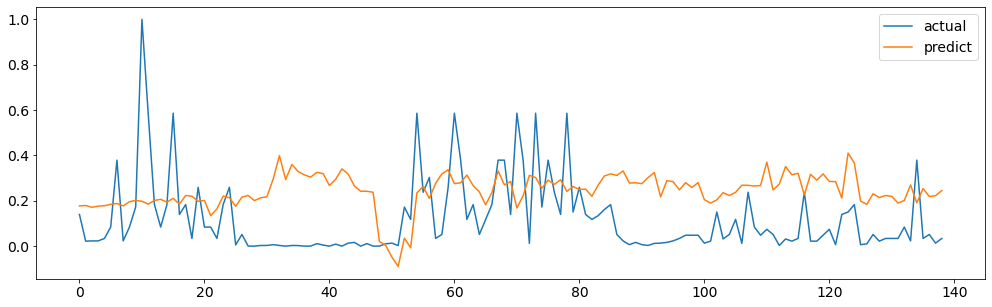

In [12]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

# Plot
fig, ax = plt.subplots(figsize=(17, 5))

Y_test = pd.DataFrame(Y_test, columns=['actual'])
predict_test = pd.DataFrame(predict_test, columns=['predict'])

Y_test.plot(ax=ax, label='actual')
predict_test.plot(ax=ax, label='predict')
#predictions.plot(ax=ax, label='predictions')
ax.legend()